In [1]:
import numpy as np

import tensorflow
import sciann as sn

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io

import pandas as pd

import h5py

---------------------- SCIANN 0.6.0.4 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 



In [2]:
print(tensorflow.__version__)

2.4.1


In [9]:
path = "NoCracK/config_file/Event0005/output.h5"

hf = h5py.File(path, 'r')

In [10]:
loc = hf['coordinates_ACOUSTIC'][:].reshape(hf['coordinates_ACOUSTIC'][:].shape[0]*hf['coordinates_ACOUSTIC'][:].shape[1],2)

df = pd.DataFrame(columns={'X','Y'})
df['X'] = loc[:,0]
df['Y'] = loc[:,1]
df['X'] = np.round(df['X'],5)
df['Y'] = np.round(df['Y'],5)

In [11]:
for i in range(101):
    df[f'ts_{i}'] = hf['volume']['phi'][i,:,:,:25].reshape(2500*25)

In [12]:
df_source = df.loc[(df['X'] == 0.125) & (df['Y'] == 0.125), (df.columns != 'X') & (df.columns != 'Y')]

Text(0, 0.5, 'Pressure')

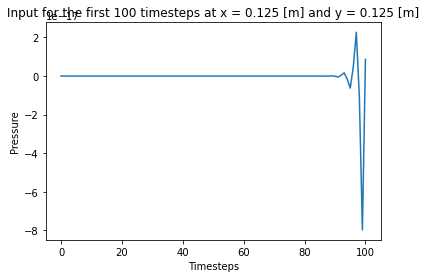

In [13]:
plt.plot(df_source.mean(axis=0).values)
plt.title(f'Input for the first 100 timesteps at x = {0.125} [m] and y = {0.125} [m]')
plt.xlabel('Timesteps')
plt.ylabel('Pressure')

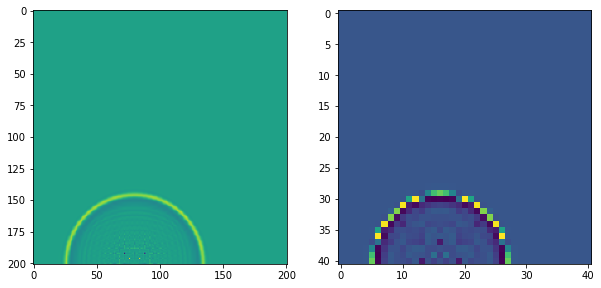

In [14]:
selected_ts = 100

df_clean = df.pivot_table(values=f'ts_{selected_ts}',index='Y',columns='X')
df_clean.sort_index(axis=0,ascending=False,inplace=True)

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(df_clean.values)
ax[1].imshow(df_clean.values[::5,::5])

In [89]:
x_data, y_data, t_data = np.meshgrid(
    np.linspace(0, 0.25, 41), 
    np.linspace(0, 0.25, 41),
    np.linspace(0, 5e-8 * 10 * 100, 101)
)

In [90]:
source_data = np.zeros(x_data.shape)
p_data = np.zeros(x_data.shape)

In [91]:
source_data[(x_data == 0.125) & (y_data == 0.125)] = df_source.mean(axis=0).values

In [110]:
# create the corresponding p-data for the training
for i in range(101):
    df_ts = df.loc[:,['X','Y',f'ts_{i}']]
    df_clean = df_ts.pivot_table(values=f'ts_{i}',index='Y',columns='X')
    p_data[:,:,i] = df_clean.values[::5,::5]


In [111]:
vp = 1400
rho = 1200

c = vp

In [112]:
x = sn.Variable('x')
y = sn.Variable('y')
t = sn.Variable('t')

p = sn.Functional('p', [x, y, t], 8*[20], 'tanh')

In [113]:
p_xx = sn.diff(p, x, order=2)
p_yy = sn.diff(p, y, order=2)
p_tt = sn.diff(p, t, order=2)

L1 = p_xx + p_yy - 1/(c**2)*p_tt
L2 = sn.Data(p)

In [114]:
# Define the optimization model (set of inputs and constraints)
model = sn.SciModel(
    inputs=[x, y, t],
    targets=[L1,L2],
    loss_func="mse"
)

In [115]:
h = model.train([x_data, y_data, t_data], [source_data, p_data], learning_rate=0.002,batch_size=256, epochs=50, verbose=1)

Train on 169781 samples
Epoch 1/50
169781/169781 [==============================] - 7s 41us/sample - loss: 47.5606 - sub_5_loss: 13.8450 - p_loss: 33.6789
Epoch 2/50
169781/169781 [==============================] - 5s 30us/sample - loss: 47.5604 - sub_5_loss: 15.0911 - p_loss: 34.9858
Epoch 3/50
169781/169781 [==============================] - 5s 31us/sample - loss: 47.5577 - sub_5_loss: 13.8444 - p_loss: 33.6657
Epoch 4/50
169781/169781 [==============================] - 5s 31us/sample - loss: 47.5567 - sub_5_loss: 13.8443 - p_loss: 33.6709
Epoch 5/50
169781/169781 [==============================] - 5s 32us/sample - loss: 47.5577 - sub_5_loss: 13.8443 - p_loss: 33.6669
Epoch 6/50
169781/169781 [==============================] - 6s 32us/sample - loss: 47.5581 - sub_5_loss: 13.8443 - p_loss: 33.6668
Epoch 7/50
169781/169781 [==============================] - 6s 33us/sample - loss: 47.5584 - sub_5_loss: 13.8443 - p_loss: 33.6696
Epoch 8/50
169781/169781 [==============================] -

In [119]:
x_test, y_test, t_test = np.meshgrid(
    np.linspace(0, 0.125, 101), 
    np.linspace(0, 0.125, 101),
    np.linspace(5e-8 * 10 * 50, 5e-8 * 10 * 50, 1)
)

In [120]:
p_preds = p.eval([x_test, y_test, t_test])

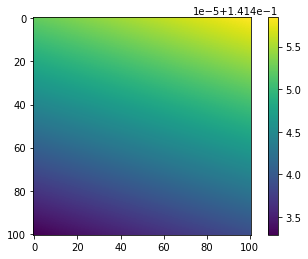

In [121]:
plt.imshow(p_preds[:,:,])
plt.colorbar()